In [1]:
# make sure nltk resources are present
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/eero/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/eero/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import re
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from string import punctuation

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.snowball import SnowballStemmer

from scipy.sparse import csr_matrix

from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.decomposition import PCA

# --------- Preprocessing ---------------

# Load the data
datapath = 'abstractdata5.csv'
with open(datapath, 'r') as f:
    lines = f.readlines()

# now combine abstract and title, and extract class info
splitted = [i.split('#') for i in lines]
classes = [int(i[1]) for i in splitted]
text = [i[2] + ' ' + i[3].rstrip() for i in splitted]

# Step 1: tokenization
tokens_list = [word_tokenize(i) for i in text]
for i, l in enumerate(tokens_list):
    tokens_list[i] = [word.lower() for word in l]

# Step 2: remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(punctuation)
filtered_tokens = []
for l in tokens_list:
    filtered_tokens.append([token for token in l if token not in stop_words])

# Step 3: stemming
stemmer = SnowballStemmer("english")
stemmed_tokens = []
for l in filtered_tokens:
    stemmed_tokens.append([stemmer.stem(word) for word in l])

# Step 4: remove numbers and join tokens
sentences = [' '.join(i) for i in stemmed_tokens]
sentences = [ re.sub(r'\d+', '', sentence) for sentence in sentences ]

# Step 5: tf-idf normalization
vectorizer = TfidfVectorizer()
tf_idf_vectors = vectorizer.fit_transform(sentences)

# create data frame as well
df = pd.DataFrame.sparse.from_spmatrix(tf_idf_vectors)

# ----------- Clustering functions -----------------

def cluster_kmeans(data_matrix):
    """Run kmeans and return predicted classes"""
    cl = KMeans(n_clusters=5)
    class_predict = cl.fit_predict(data_matrix)
    return class_predict

def cluster_spectral(data_matrix):
    cl = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=200)
    class_predict = cl.fit_predict(data_matrix)
    return class_predict

def cluster_hier(data_matrix):
    cl = AgglomerativeClustering(n_clusters=5, linkage='ward')
    try:
      dense_data = data_matrix.toarray()
    except AttributeError:
      dense_data = data_matrix

    class_predict = cl.fit_predict(dense_data)
    return class_predict

def print_most_common_words(predicted_classes, nwords):
    """Print out most common words within a class"""
    assert len(predicted_classes) == len(stemmed_tokens)
    # check how many classes there are
    unique = np.unique(predicted_classes)
    # store all words within class
    all_words = {}
    for cl in unique:
        all_words[cl] = []
    for i in range(len(stemmed_tokens)):
        cl = predicted_classes[i]
        sentence = stemmed_tokens[i]
        all_words[cl].extend(sentence)
    # show most common words
    for cl in unique:
        freq = FreqDist(all_words[cl])
        print(f"\nClass {cl} most common words are:")
        words = [f'{word[0]}({word[1]}) ' for word in freq.most_common(nwords)]
        print(' '.join(words))

In [3]:
# ------------- Feature engineering -------------------------

X = tf_idf_vectors
y = classes

# Select k best features based on mutual info regression
X_kbest = SelectKBest(mutual_info_regression, k=1000).fit_transform(X, y)

# Take pca components
X_pca = PCA(n_components=10).fit_transform(X.toarray())

,K-means,Spectral,Hierarchical
Plain,0.692282,0.781041,0.443392
K best,0.292015,0.242199,0.311420
PCA,0.656717,0.790359,0.611956


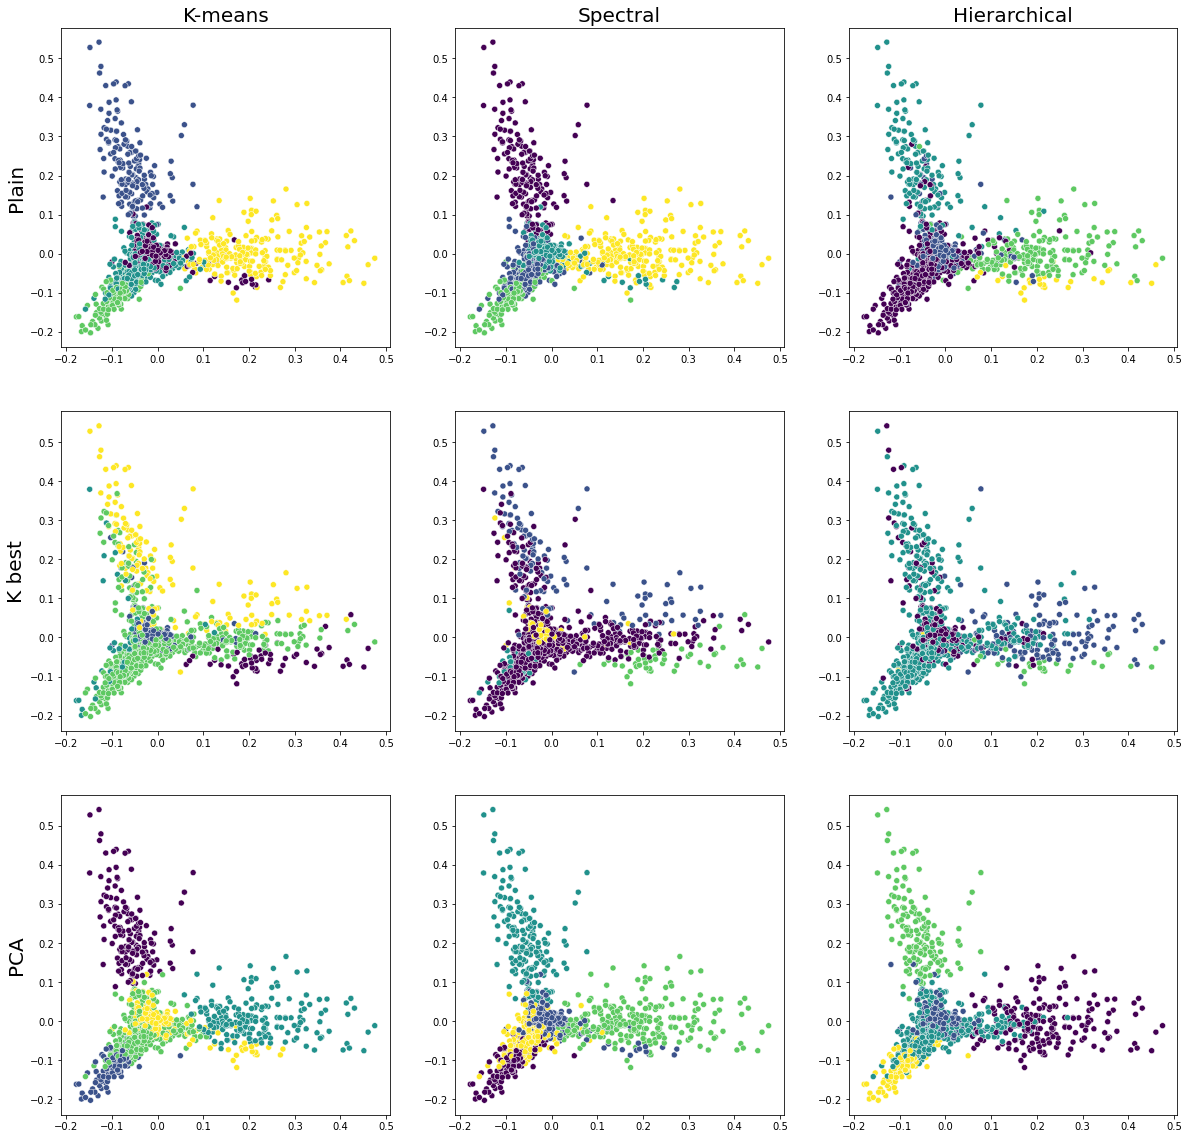

In [4]:
# ------------ Run the clustering ---------------

cluster_functions = [cluster_kmeans, cluster_spectral, cluster_hier]
plain_results, kbest_results, pca_results = [], [], []
plot_components = PCA(n_components=2).fit_transform(tf_idf_vectors.toarray())
x = plot_components[:, 0]
y = plot_components[:, 1]

plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
fig, ax = plt.subplots(3, 3, figsize=(20,20))
ax[0, 0].set_ylabel('Plain')
ax[1, 0].set_ylabel('K best')
ax[2, 0].set_ylabel('PCA')
ax[0, 0].set_title('K-means')
ax[0, 1].set_title('Spectral')
ax[0, 2].set_title('Hierarchical')

# run each function with its respective dataset
for i, cl_func in enumerate(cluster_functions):
  # plain
  plain_predict = cl_func(X)
  plain_score = nmi(classes, plain_predict, average_method='geometric')
  plain_results.append(plain_score)
  sns.scatterplot(x=x, y=y, c=plain_predict, ax=ax[0, i])

  # kbest
  kbest_predict = cl_func(X_kbest)
  kbest_score = nmi(classes, kbest_predict, average_method='geometric')
  kbest_results.append(kbest_score)
  sns.scatterplot(x=x, y=y, c=kbest_predict, ax=ax[1, i])

  # pca
  pca_predict = cl_func(X_pca)
  pca_score = nmi(classes, pca_predict, average_method='geometric')
  pca_results.append(pca_score)
  sns.scatterplot(x=x, y=y, c=pca_predict, ax=ax[2, i])


# consruct a dataframe with our results
results = pd.DataFrame(
    data={'Plain': plain_results,
          'K best': kbest_results,
          'PCA': pca_results},
    index=['K-means', 'Spectral', 'Hierarchical']
).transpose()
display(results)

In [5]:
# show most common words in each cluster based
# on spectral 
cl_predictions = cluster_spectral(X_pca)
print_most_common_words(cl_predictions, 20)


Class 0 most common words are:
secur(687)  use(409)  propos(377)  scheme(340)  data(326)  encrypt(301)  key(285)  comput(258)  cryptographi(251)  system(236)  protocol(234)  base(229)  attack(226)  algorithm(225)  quantum(222)  implement(187)  applic(155)  paper(150)  provid(148)  effici(147) 

Class 1 most common words are:
compil(585)  program(371)  use(336)  comput(273)  code(252)  languag(242)  optim(209)  system(205)  implement(180)  applic(169)  paper(168)  algorithm(166)  design(154)  memori(152)  graph(150)  parallel(147)  perform(144)  present(138)  time(134)  approach(131) 

Class 2 most common words are:
use(707)  imag(647)  method(566)  detect(483)  propos(473)  model(464)  comput(387)  system(384)  perform(345)  learn(333)  network(325)  vision(318)  result(306)  data(294)  base(280)  algorithm(279)  object(261)  approach(254)  dataset(246)  featur(238) 

Class 3 most common words are:
databas(675)  data(579)  relat(358)  system(302)  queri(271)  use(269)  model(194)  inf